# Ricci Flow Layer Depth Study
## DNN Training for Varying Layer Depths (3-30)

This notebook trains DNNs with varying layer depths across three architectures (Narrow, Wide, Bottleneck) on MNIST 4 vs 9 binary classification.

**Purpose:** Generate activations for Ricci curvature analysis to study how layer depth affects Ricci flow-like behavior.

**Based on:** `training.py` and theoretical framework from "Deep Learning as Ricci Flow" (Baptista et al., 2024)

## 1. Setup & GPU Detection

In [1]:
# ============================================================================
# GOOGLE DRIVE MOUNT & PATH SETUP
# ============================================================================
from google.colab import drive
import os

# Google Drive'ı sisteme bağla
drive.mount('/content/drive')

# Çıktı yolunu Drive olarak güncelle
# 'ricci_study' klasörünü Drive ana dizininde otomatik oluşturur
OUTPUT_DIR = '/content/drive/MyDrive/ricci_layer_depth_study_outputs'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"✓ Drive üzerinde çıktı klasörü oluşturuldu: {OUTPUT_DIR}")
else:
    print(f"✓ Çıktılar Drive üzerindeki bu klasöre kaydedilecek: {OUTPUT_DIR}")

Mounted at /content/drive
✓ Çıktılar Drive üzerindeki bu klasöre kaydedilecek: /content/drive/MyDrive/ricci_layer_depth_study_outputs


In [2]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import pandas as pd
import os
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist

# ============================================================================
# GPU DETECTION (for Kaggle/Colab)
# ============================================================================
print("=" * 60)
print("DEVICE DETECTION")
print("=" * 60)

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU(s) detected: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
    # Enable memory growth to avoid OOM
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠ GPU memory growth setting failed: {e}")
else:
    print("⚠ No GPU detected. Training will use CPU.")
    print("  Tip: Enable GPU in Kaggle/Colab settings for faster training.")

print(f"\nTensorFlow version: {tf.__version__}")
print("=" * 60)

DEVICE DETECTION
⚠ No GPU detected. Training will use CPU.
  Tip: Enable GPU in Kaggle/Colab settings for faster training.

TensorFlow version: 2.19.0


## 2. Configuration

In [3]:
# ============================================================================
# CONFIGURATION (UPDATED: 2-step layers, 10 models)
# ============================================================================

# Problem definition
DIGIT_A = 4
DIGIT_B = 9

# Layer depths to test (3'ten 30'a kadar 2'şer atlayarak: 3, 5, 7, ..., 29)
LAYER_DEPTHS = list(range(3, 31, 2))

# Architecture configurations
ARCHITECTURES = {
    'narrow': {'width': 25, 'bottleneck': False},
    'wide': {'width': 50, 'bottleneck': False},
    'bottleneck': {'width': 50, 'bottleneck': True}
}

# Training parameters
NUM_MODELS = 10  # Her konfigürasyon için model sayısı 10'a düşürüldü
EPOCHS = 50
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EARLY_STOP_ACCURACY = 0.99

# Output directory (Google Drive yolu kullanılması önerilir)
# Önceki adımda Drive mount ettiysen burayı Drive yoluyla güncelle:
# OUTPUT_DIR = '/content/drive/MyDrive/ricci_layer_depth_study_outputs'
OUTPUT_DIR = 'layer_depth_study_outputs'

print("Yeni Konfigürasyon:")
print(f"  Katman Derinlikleri: {LAYER_DEPTHS}")
print(f"  Model Sayısı (Her derinlik için): {NUM_MODELS}")
print(f"  Toplam Eğitim Sayısı: {len(ARCHITECTURES) * len(LAYER_DEPTHS) * NUM_MODELS}")

Yeni Konfigürasyon:
  Katman Derinlikleri: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
  Model Sayısı (Her derinlik için): 10
  Toplam Eğitim Sayısı: 420


## 3. Data Loading (MNIST 4 vs 9)

In [4]:
# ============================================================================
# DATA LOADING
# ============================================================================

def load_mnist_binary(digit_a, digit_b):
    """Load MNIST data filtered for binary classification."""
    # Load full MNIST
    (x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

    # Filter for our two digits
    train_mask = (y_train_full == digit_a) | (y_train_full == digit_b)
    test_mask = (y_test_full == digit_a) | (y_test_full == digit_b)

    x_train = x_train_full[train_mask]
    y_train = y_train_full[train_mask]
    x_test = x_test_full[test_mask]
    y_test = y_test_full[test_mask]

    # Flatten images (28x28 -> 784)
    x_train = x_train.reshape(-1, 784).astype('float32')
    x_test = x_test.reshape(-1, 784).astype('float32')

    # Normalize to [0, 1]
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Convert labels to binary (digit_a -> 0, digit_b -> 1)
    y_train = (y_train == digit_b).astype('int32')
    y_test = (y_test == digit_b).astype('int32')

    return x_train, y_train, x_test, y_test

# Load data
print("Loading MNIST data...")
x_train, y_train, x_test, y_test = load_mnist_binary(DIGIT_A, DIGIT_B)

print(f"\nDataset loaded:")
print(f"  Training samples: {x_train.shape[0]} (Class 0: {np.sum(y_train==0)}, Class 1: {np.sum(y_train==1)})")
print(f"  Test samples: {x_test.shape[0]} (Class 0: {np.sum(y_test==0)}, Class 1: {np.sum(y_test==1)})")
print(f"  Feature dimension: {x_train.shape[1]}")

Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Dataset loaded:
  Training samples: 11791 (Class 0: 5842, Class 1: 5949)
  Test samples: 1991 (Class 0: 982, Class 1: 1009)
  Feature dimension: 784


## 4. Model Architecture Builders

In [5]:
# ============================================================================
# ARCHITECTURE BUILDERS
# ============================================================================

def build_dnn(arch_name, arch_config, depth, input_dim):
    """
    Build DNN model based on architecture configuration.

    Based on training.py structure:
    - Narrow: 25 neurons per layer
    - Wide: 50 neurons per layer
    - Bottleneck: 50 neurons first layer, 25 for rest
    """
    model = Sequential()

    width = arch_config['width']
    is_bottleneck = arch_config['bottleneck']

    # First hidden layer
    if is_bottleneck:
        model.add(Dense(units=50, activation='relu', input_shape=(input_dim,)))
    else:
        model.add(Dense(units=width, activation='relu', input_shape=(input_dim,)))

    # Remaining hidden layers (depth - 1 more layers)
    for _ in range(depth - 1):
        if is_bottleneck:
            model.add(Dense(units=25, activation='relu'))
        else:
            model.add(Dense(units=width, activation='relu'))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile (based on training.py)
    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(),
        metrics=['accuracy']
    )

    return model


# Test architecture building
print("Testing architecture builders...")
for arch_name, arch_config in ARCHITECTURES.items():
    test_model = build_dnn(arch_name, arch_config, depth=5, input_dim=784)
    print(f"  {arch_name}: {len(test_model.layers)} layers ({test_model.count_params()} params)")
print("✓ All architectures build successfully")

Testing architecture builders...
  narrow: 6 layers (22251 params)
  wide: 6 layers (49501 params)
  bottleneck: 6 layers (42501 params)
✓ All architectures build successfully


## 5. Training Function with Early Stopping

In [6]:
# ============================================================================
# TRAINING FUNCTION
# ============================================================================

class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    """Stop training when training accuracy reaches threshold."""
    def __init__(self, threshold=0.99):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.threshold:
            self.model.stop_training = True


def train_single_model(arch_name, arch_config, depth, x_train, y_train, x_test, y_test):
    """
    Train a single DNN model and extract activations.

    Returns:
        activations: list of numpy arrays (one per hidden layer)
        accuracy: test accuracy
    """
    # Build model
    model = build_dnn(arch_name, arch_config, depth, input_dim=x_train.shape[1])

    # Early stopping callback (stop at 99% training accuracy)
    early_stop = AccuracyThresholdCallback(threshold=EARLY_STOP_ACCURACY)

    # Train model (based on training.py)
    model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate on test set
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)

    # Extract activations from all hidden layers (exclude output layer)
    # Based on training.py: model_predict[j] = activations
    activations = []
    current_input = x_test
    for layer in model.layers[:-1]:  # Exclude output layer
        current_output = layer(current_input)
        activations.append(current_output.numpy())
        current_input = current_output

    return activations, accuracy


print("Training function defined.")
print(f"  Early stopping: Training accuracy >= {EARLY_STOP_ACCURACY*100}%")

Training function defined.
  Early stopping: Training accuracy >= 99.0%


## 6. Output Directory Structure

In [7]:
# ============================================================================
# OUTPUT STRUCTURE HELPER
# ============================================================================

def create_output_dirs():
    """
    Create output directory structure:

    layer_depth_study_outputs/
    ├── narrow/
    │   ├── depth_3/
    │   │   └── models_b25/
    │   ├── depth_4/
    │   └── ...
    ├── wide/
    │   └── ...
    └── bottleneck/
        └── ...
    """
# ============================================================================
# OUTPUT STRUCTURE HELPER (UPDATED)
# ============================================================================

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    for arch_name in ARCHITECTURES.keys():
        for depth in LAYER_DEPTHS:
            # Klasör ismi otomatik olarak models_b10 olacaktır
            path = os.path.join(OUTPUT_DIR, arch_name, f"depth_{depth}", f"models_b{NUM_MODELS}")
            os.makedirs(path, exist_ok=True)
    print(f"✓ Klasör yapısı güncellendi: {OUTPUT_DIR}/")

def save_model_outputs(arch_name, depth, model_predict, accuracy_list, x_test, y_test):
    output_path = os.path.join(OUTPUT_DIR, arch_name, f"depth_{depth}", f"models_b{NUM_MODELS}")
    np.save(os.path.join(output_path, "model_predict.npy"), model_predict)
    np.save(os.path.join(output_path, "accuracy.npy"), np.array(accuracy_list))
    pd.DataFrame(x_test).to_csv(os.path.join(output_path, "x_test.csv"), index=False, header=None)
    pd.DataFrame(y_test).to_csv(os.path.join(output_path, "y_test.csv"), index=False, header=None)

# Klasörleri oluştur/güncelle
create_output_dirs()

✓ Klasör yapısı güncellendi: layer_depth_study_outputs/


## 7. Main Training Loop

In [8]:
# ============================================================================
# MAIN TRAINING LOOP (WITH CHECKPOINTING)
# ============================================================================

# Storage for summary CSV
summary_results = []

# Total configurations
total_configs = len(ARCHITECTURES) * len(LAYER_DEPTHS)
config_count = 0

print("=" * 80)
print("TRAINING STARTED")
print(f"Total configurations: {total_configs}")
print(f"Models per configuration: {NUM_MODELS}")
print("=" * 80)

start_time_total = time.time()

# Loop over architectures
for arch_name, arch_config in ARCHITECTURES.items():
    print(f"\n{'='*60}")
    print(f"ARCHITECTURE: {arch_name.upper()}")
    print(f"{'='*60}")

    # Loop over layer depths
    for depth in tqdm(LAYER_DEPTHS, desc=f"{arch_name} depths"):
        config_count += 1

        # --- CHECKPOINT KONTROLÜ ---
        # Bu derinlik için sonuçlar zaten kaydedilmiş mi bakıyoruz
        output_path = os.path.join(OUTPUT_DIR, arch_name, f"depth_{depth}", f"models_b{NUM_MODELS}")
        checkpoint_file = os.path.join(output_path, "model_predict.npy")

        if os.path.exists(checkpoint_file):
            tqdm.write(f"  [SKIP] Depth {depth} already exists in Drive. Skipping...")
            # Mevcut doğruluğu summary listesine ekle (İstatistiklerin tam olması için)
            if os.path.exists(os.path.join(output_path, "accuracy.npy")):
                acc_vals = np.load(os.path.join(output_path, "accuracy.npy"))
                summary_results.append({
                    'architecture': arch_name, 'depth': depth, 'num_models': NUM_MODELS,
                    'mean_accuracy': np.mean(acc_vals), 'std_accuracy': np.std(acc_vals),
                    'min_accuracy': np.min(acc_vals), 'max_accuracy': np.max(acc_vals)
                })
            continue
        # ---------------------------

        # Storage for this configuration
        model_predict = np.empty(NUM_MODELS, dtype=object)
        accuracy_list = []

        # Train NUM_MODELS models
        for j in range(NUM_MODELS):
            activations, accuracy = train_single_model(
                arch_name, arch_config, depth,
                x_train, y_train, x_test, y_test
            )
            model_predict[j] = activations
            accuracy_list.append(accuracy)

        # Save outputs (Drive'a kaydedilir)
        # save_model_outputs fonksiyonunun OUTPUT_DIR kullandığından emin olun
        save_model_outputs(arch_name, depth, model_predict, accuracy_list, x_test, y_test)

        # Store summary statistics
        mean_acc = np.mean(accuracy_list)
        std_acc = np.std(accuracy_list)

        summary_results.append({
            'architecture': arch_name,
            'depth': depth,
            'num_models': NUM_MODELS,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': np.min(accuracy_list),
            'max_accuracy': np.max(accuracy_list)
        })

        if depth % 7 == 0:
            tqdm.write(f"  depth={depth}: mean_acc={mean_acc:.4f} ± {std_acc:.4f}")

total_time = time.time() - start_time_total

print(f"\n{'='*80}")
print(f"TRAINING COMPLETE!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"{'='*80}")

TRAINING STARTED
Total configurations: 42
Models per configuration: 10

ARCHITECTURE: NARROW


narrow depths:   0%|          | 0/14 [00:00<?, ?it/s]

  depth=7: mean_acc=0.9847 ± 0.0039
  depth=21: mean_acc=0.6021 ± 0.1907

ARCHITECTURE: WIDE


wide depths:   0%|          | 0/14 [00:00<?, ?it/s]

  depth=7: mean_acc=0.9840 ± 0.0089
  depth=21: mean_acc=0.9369 ± 0.1434

ARCHITECTURE: BOTTLENECK


bottleneck depths:   0%|          | 0/14 [00:00<?, ?it/s]

  depth=7: mean_acc=0.9854 ± 0.0034
  depth=21: mean_acc=0.7940 ± 0.2345

TRAINING COMPLETE!
Total time: 173.6 minutes


## 8. Save Summary CSV

In [9]:
# ============================================================================
# SAVE SUMMARY CSV
# ============================================================================

# Create DataFrame
summary_df = pd.DataFrame(summary_results)

# Save to CSV
summary_csv_path = os.path.join(OUTPUT_DIR, 'training_summary.csv')
summary_df.to_csv(summary_csv_path, index=False)

print(f"Summary saved to: {summary_csv_path}")
print(f"\nSummary statistics:")
print(summary_df.to_string(index=False))

Summary saved to: layer_depth_study_outputs/training_summary.csv

Summary statistics:
architecture  depth  num_models  mean_accuracy  std_accuracy  min_accuracy  max_accuracy
      narrow      3          10       0.984430      0.004598      0.972376      0.989453
      narrow      5          10       0.985836      0.003127      0.977901      0.990457
      narrow      7          10       0.984681      0.003886      0.977398      0.988950
      narrow      9          10       0.983777      0.003088      0.977398      0.987946
      narrow     11          10       0.984982      0.002575      0.980412      0.989955
      narrow     13          10       0.985886      0.001657      0.981416      0.987444
      narrow     15          10       0.983677      0.004829      0.971873      0.988950
      narrow     17          10       0.984078      0.002610      0.978905      0.987946
      narrow     19          10       0.841085      0.218876      0.506781      0.988448
      narrow     21     

## 9. Quick Visualization

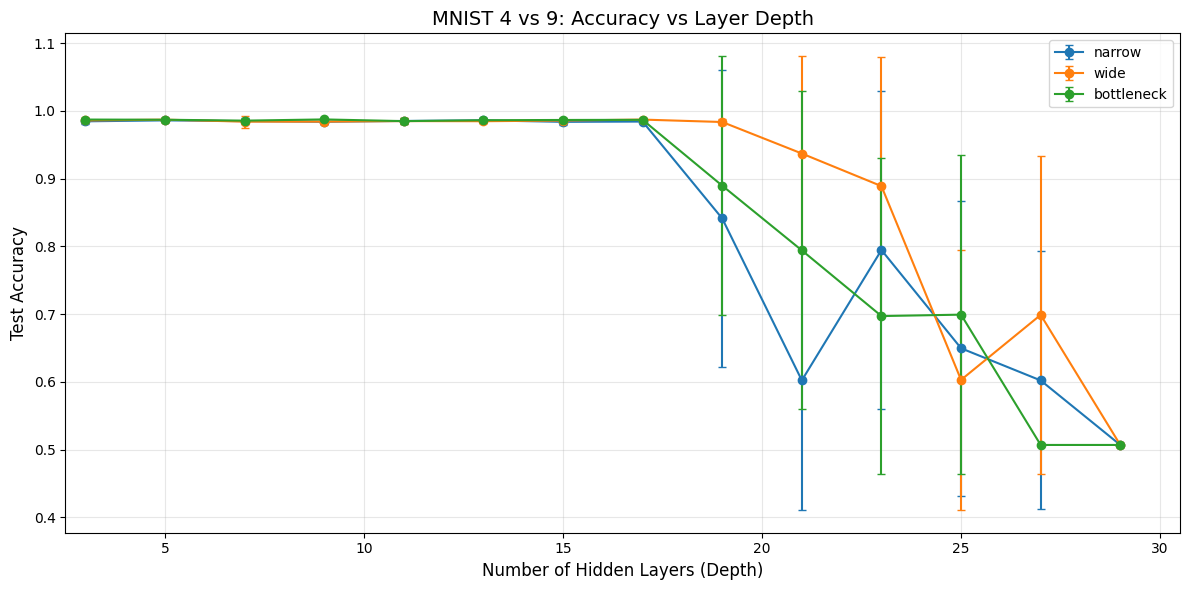


✓ Visualization saved to: layer_depth_study_outputs/accuracy_vs_depth.png


In [10]:
# ============================================================================
# QUICK VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for arch_name in ARCHITECTURES.keys():
    arch_data = summary_df[summary_df['architecture'] == arch_name]
    ax.errorbar(
        arch_data['depth'],
        arch_data['mean_accuracy'],
        yerr=arch_data['std_accuracy'],
        label=arch_name,
        marker='o',
        capsize=3
    )

ax.set_xlabel('Number of Hidden Layers (Depth)', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_title(f'MNIST {DIGIT_A} vs {DIGIT_B}: Accuracy vs Layer Depth', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([2.5, 30.5])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_vs_depth.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {OUTPUT_DIR}/accuracy_vs_depth.png")

## 10. Verification & Next Steps

In [11]:
# ============================================================================
# VERIFICATION
# ============================================================================

print("=" * 60)
print("VERIFICATION")
print("=" * 60)

# Check a sample output
sample_path = os.path.join(OUTPUT_DIR, 'narrow', 'depth_5', f'models_b{NUM_MODELS}')
print(f"\nChecking sample output: {sample_path}")

# Load and verify
sample_acc = np.load(os.path.join(sample_path, 'accuracy.npy'))
sample_model = np.load(os.path.join(sample_path, 'model_predict.npy'), allow_pickle=True)

print(f"  accuracy.npy shape: {sample_acc.shape}")
print(f"  accuracy range: [{sample_acc.min():.4f}, {sample_acc.max():.4f}]")
print(f"  model_predict.npy: {len(sample_model)} models")
print(f"  Activations per model: {len(sample_model[0])} layers")
print(f"  Activation shapes: {[a.shape for a in sample_model[0]]}")

print("\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("""
The outputs are now ready for Ricci curvature analysis using knn_fixed.py.

For each architecture/depth combination:
  1. Load model_predict.npy and x_test.csv
  2. Build kNN graphs on activations
  3. Compute Forman-Ricci curvature
  4. Correlate with accuracy from training_summary.csv
""")

VERIFICATION

Checking sample output: layer_depth_study_outputs/narrow/depth_5/models_b10
  accuracy.npy shape: (10,)
  accuracy range: [0.9779, 0.9905]
  model_predict.npy: 10 models
  Activations per model: 5 layers
  Activation shapes: [(1991, 25), (1991, 25), (1991, 25), (1991, 25), (1991, 25)]

NEXT STEPS

The outputs are now ready for Ricci curvature analysis using knn_fixed.py.

For each architecture/depth combination:
  1. Load model_predict.npy and x_test.csv
  2. Build kNN graphs on activations
  3. Compute Forman-Ricci curvature
  4. Correlate with accuracy from training_summary.csv



---
# Part 2: Ricci Curvature Analysis
## kNN Graph Building & Forman-Ricci Computation

Based on `knn_fixed.py` from the paper's methodology.

## 11. kNN Graph Building Functions

In [12]:
# ============================================================================
# kNN GRAPH BUILDING (from knn_fixed.py)
# ============================================================================
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, triu as sp_triu
from scipy.sparse.csgraph import shortest_path
from scipy.stats import pearsonr, spearmanr
from typing import List, Dict, Tuple

def build_knn_graph(X: np.ndarray, k: int) -> csr_matrix:
    """
    Return an undirected, unweighted kNN adjacency in CSR format.

    Based on knn_fixed.py:
    - Symmetrize kNN (mutualization by max)
    - Set diagonal to 0

    Args:
        X: Data matrix (n_samples, n_features)
        k: Number of nearest neighbors

    Returns:
        csr_matrix: Symmetric adjacency matrix
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if X.dtype != np.float32 and X.dtype != np.float64:
        X = X.astype(np.float32, copy=False)

    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(X)
    A = knn.kneighbors_graph(X, mode='connectivity')  # (n, n) sparse {0, 1}

    # Symmetrize (undirected graph)
    A = A.maximum(A.T)

    # Zero-out diagonal (no self-loops)
    A.setdiag(0)
    A.eliminate_zeros()

    return A.tocsr()

print("✓ build_knn_graph() defined")

✓ build_knn_graph() defined


## 12. Geodesic Mass Computation

In [13]:
# ============================================================================
# GEODESIC MASS (from knn_fixed.py)
# ============================================================================

def sum_shortest_paths(A: csr_matrix) -> float:
    """
    Compute geodesic mass g = sum of all-pairs shortest-path distances (i < j).

    From the paper (Eq. 7):
        g_l = sum_{i<j} gamma_l(i, j)

    where gamma_l(i,j) is the shortest-path distance on the kNN graph.

    If graph is disconnected, infinite distances are discarded.
    """
    dist = shortest_path(A, directed=False, unweighted=True)

    # Take upper triangle (i < j)
    iu = np.triu_indices_from(dist, k=1)
    vals = dist[iu]

    # Handle disconnected components
    finite = np.isfinite(vals)
    if not np.all(finite):
        missing = (~finite).sum()
        print(f"  [WARN] Disconnected graph: {missing} pair distances are inf; they will be ignored.")
        vals = vals[finite]

    return float(vals.sum())

print("✓ sum_shortest_paths() defined")

✓ sum_shortest_paths() defined


## 13. Forman-Ricci Curvature

In [14]:
# ============================================================================
# FORMAN-RICCI CURVATURE (from knn_fixed.py)
# ============================================================================

def global_forman_ricci(A: csr_matrix) -> float:
    """
    Compute global Forman-Ricci curvature coefficient.

    From the paper (Eq. 4):
        R(i, j) = 4 - deg(i) - deg(j)  for unit edge weights

    Global Ricci coefficient (Eq. 6):
        Ric_l = sum_{(i,j) in E_l} R_l(i, j)

    For undirected graph, count each edge once (upper triangle).
    """
    # Compute degree per node
    deg = np.asarray(A.sum(axis=1)).ravel()

    # Use upper triangle to count undirected edges once
    A_ut = sp_triu(A, k=1).tocoo()

    # Forman-Ricci curvature per edge: R(i,j) = 4 - deg(i) - deg(j)
    curv = 4.0 - deg[A_ut.row] - deg[A_ut.col]

    return float(curv.sum())

print("✓ global_forman_ricci() defined")

✓ global_forman_ricci() defined


## 14. Layer-wise Analysis Function

In [15]:
# ============================================================================
# LAYER-WISE ANALYSIS (from knn_fixed.py)
# ============================================================================

def analyze_model_layers(activations: List[np.ndarray], X0: np.ndarray, k: int) -> Dict[str, np.ndarray]:
    """
    For one model: build graphs, compute (g_l, Ric_l) for l=0..L.

    l=0 refers to baseline on the raw test input X0.

    Args:
        activations: List of activation arrays from each hidden layer
        X0: Original test input data
        k: Number of nearest neighbors for kNN graph

    Returns:
        dict with:
            'g': array of geodesic masses (L+1 values)
            'Ric': array of Ricci curvatures (L+1 values)
    """
    # Baseline graph on input space (l=0)
    A0 = build_knn_graph(X0, k)
    g0 = sum_shortest_paths(A0)
    Ric0 = global_forman_ricci(A0)

    g_list = [g0]
    ric_list = [Ric0]

    # Hidden layers (l=1..L)
    for l, Xl in enumerate(activations, start=1):
        A = build_knn_graph(np.asarray(Xl), k)
        g_list.append(sum_shortest_paths(A))
        ric_list.append(global_forman_ricci(A))

    return {
        'g': np.array(g_list, dtype=float),
        'Ric': np.array(ric_list, dtype=float)
    }

print("✓ analyze_model_layers() defined")

✓ analyze_model_layers() defined


## 15. Model Collection Analysis

In [16]:
# ============================================================================
# COLLECT ACROSS MODELS (from knn_fixed.py)
# ============================================================================

def collect_across_models(models: List, X0: np.ndarray, k: int,
                          acc: np.ndarray, acc_threshold: float = 0.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run analysis over models passing the accuracy threshold.

    Returns two long DataFrames:
        - mfr: Forman-Ricci curvature per layer/model
            columns: [layer, mod, ssr] where ssr = Ric_{l-1}
        - msc: Geodesic change per layer/model
            columns: [layer, mod, ssr] where ssr = delta_g_l = g_l - g_{l-1}

    The paper correlates delta_g_l with Ric_{l-1} (layer-skip).
    """
    keep = np.where(acc > acc_threshold)[0]
    if keep.size == 0:
        print(f"  WARNING: No models exceed threshold {acc_threshold}. Using all models.")
        keep = np.arange(len(models))

    rows_fr = []  # Forman-Ricci
    rows_sc = []  # Shortest-path change (geodesic change)

    for m in keep:
        acts = models[m]
        res = analyze_model_layers(acts, X0, k)
        g = res['g']       # length L+1 (including baseline)
        Ric = res['Ric']   # length L+1
        L = len(acts)      # number of hidden layers

        # Δg_l = g_l - g_{l-1} for l=1..L
        dgs = g[1:] - g[:-1]

        # Store results
        for l in range(1, L + 1):
            rows_sc.append({'layer': l, 'mod': int(m), 'ssr': float(dgs[l-1])})
            rows_fr.append({'layer': l-1, 'mod': int(m), 'ssr': float(Ric[l-1])})

    msc = pd.DataFrame(rows_sc, columns=['layer', 'mod', 'ssr'])  # Δg_l
    mfr = pd.DataFrame(rows_fr, columns=['layer', 'mod', 'ssr'])  # Ric_{l-1}

    return mfr, msc

print("✓ collect_across_models() defined")

✓ collect_across_models() defined


## 16. Correlation Analysis

In [17]:
# ============================================================================
# CORRELATION ANALYSIS (from knn_fixed.py)
# ============================================================================

def correlation_report(mfr: pd.DataFrame, msc: pd.DataFrame) -> Dict[str, float]:
    """
    Compute overall Pearson correlations between Δg_l and Ric_{l-1}.

    From the paper (Eq. 5):
        g_{l+1} - g_l ≈ -α * Ric(g_l)

    We correlate:
        - msc (Δg_l at layer l) with mfr (Ric at layer l-1)
        - r_all: all layers included
        - r_skip: excludes layer 1 (first hidden layer)
    """
    # Shift mfr layers by +1 to align Ric_{l-1} with Δg_l
    mfr_shifted = mfr.copy()
    mfr_shifted['layer'] = mfr_shifted['layer'] + 1

    # Merge on (mod, layer)
    merged = msc.merge(mfr_shifted, on=['mod', 'layer'], how='inner', suffixes=('_dg', '_fr'))

    if len(merged) < 2:
        return {'r_all': np.nan, 'p_all': np.nan, 'r_skip': np.nan, 'p_skip': np.nan}

    # Pearson correlation (all layers)
    r_all, p_all = pearsonr(merged['ssr_dg'].values, merged['ssr_fr'].values)

    # Pearson correlation (skip layer 1)
    merged_skip = merged[merged['layer'] != 1]
    if len(merged_skip) < 2:
        r_skip, p_skip = np.nan, np.nan
    else:
        r_skip, p_skip = pearsonr(merged_skip['ssr_dg'].values, merged_skip['ssr_fr'].values)

    return {
        'r_all': float(r_all),
        'p_all': float(p_all),
        'r_skip': float(r_skip),
        'p_skip': float(p_skip)
    }

print("✓ correlation_report() defined")

✓ correlation_report() defined


## 17. Aggregated Ricci Coefficient (rho)

In [18]:
# ============================================================================
# AGGREGATED RICCI COEFFICIENT (rho) - For Accuracy Comparison
# ============================================================================

def compute_aggregated_ricci(activations: List[np.ndarray], X0: np.ndarray, k: int) -> float:
    """
    Compute the aggregated Ricci coefficient (rho) for a single model.

    From the paper (Eq. 10):
        Ric = (1 / (L-1)) * sum_{l=1}^{L-1} Ric_l

    This is the mean Ricci curvature across all layers, used to
    correlate with model accuracy.
    """
    res = analyze_model_layers(activations, X0, k)
    ric_values = res['Ric']  # [Ric_0, Ric_1, ..., Ric_L]

    # Mean over all layers (including input layer)
    rho = np.mean(ric_values)

    return rho


def compute_rho_for_configuration(model_dir: str, k: int, acc_threshold: float = 0.0) -> Dict:
    """
    Compute aggregated Ricci coefficient for all models in a configuration.

    Returns:
        dict with:
            'mean_rho': mean aggregated Ricci across models
            'std_rho': std of aggregated Ricci
            'rho_list': list of rho values per model
            'n_models': number of models analyzed
    """
    # Load model outputs
    model_predict = np.load(os.path.join(model_dir, 'model_predict.npy'), allow_pickle=True)
    accuracy = np.load(os.path.join(model_dir, 'accuracy.npy'))
    X0 = pd.read_csv(os.path.join(model_dir, 'x_test.csv'), header=None).values

    # Filter by accuracy threshold
    keep = np.where(accuracy > acc_threshold)[0]
    if len(keep) == 0:
        keep = np.arange(len(model_predict))

    # Compute rho for each model
    rho_list = []
    for m in keep:
        rho = compute_aggregated_ricci(model_predict[m], X0, k)
        rho_list.append(rho)

    return {
        'mean_rho': np.mean(rho_list),
        'std_rho': np.std(rho_list),
        'rho_list': rho_list,
        'n_models': len(rho_list)
    }

print("✓ compute_aggregated_ricci() defined")
print("✓ compute_rho_for_configuration() defined")

✓ compute_aggregated_ricci() defined
✓ compute_rho_for_configuration() defined


## 18. Test kNN Graph Functions

In [19]:
# ============================================================================
# TEST kNN GRAPH FUNCTIONS
# ============================================================================

print("Testing kNN graph functions on sample data...")
print("=" * 60)

# Create sample data (small subset for quick test)
sample_X = x_test[:200]  # First 200 test samples
test_k = 20  # Small k for testing

# Build kNN graph
print(f"\n1. Building kNN graph (k={test_k}, n={sample_X.shape[0]})...")
A = build_knn_graph(sample_X, test_k)
print(f"   Graph shape: {A.shape}")
print(f"   Number of edges: {A.nnz // 2}")  # Divide by 2 for undirected
print(f"   Density: {A.nnz / (A.shape[0] ** 2):.4f}")

# Compute geodesic mass
print(f"\n2. Computing geodesic mass (sum of shortest paths)...")
g = sum_shortest_paths(A)
print(f"   Geodesic mass g = {g:.2e}")

# Compute Forman-Ricci curvature
print(f"\n3. Computing global Forman-Ricci curvature...")
Ric = global_forman_ricci(A)
print(f"   Global Ricci Ric = {Ric:.2e}")

print("\n" + "=" * 60)
print("✓ All kNN graph functions working correctly!")

Testing kNN graph functions on sample data...

1. Building kNN graph (k=20, n=200)...
   Graph shape: (200, 200)
   Number of edges: 2684
   Density: 0.1342

2. Computing geodesic mass (sum of shortest paths)...
   Geodesic mass g = 4.35e+04

3. Computing global Forman-Ricci curvature...
   Global Ricci Ric = -1.44e+05

✓ All kNN graph functions working correctly!


## 19. Ricci Analysis Configuration

In [20]:
# ============================================================================
# RICCI ANALYSIS CONFIGURATION
# ============================================================================

# k-NN parameter for graph construction
# Paper recommends ~10-25% of test samples
# For ~2000 test samples, k=200-500 is reasonable
K_VALUE = 200  # Adjust based on your test set size

# Accuracy threshold (use 0.0 to include all models)
RICCI_ACC_THRESHOLD = 0.0

print(f"Ricci Analysis Configuration:")
print(f"  k (nearest neighbors): {K_VALUE}")
print(f"  Accuracy threshold: {RICCI_ACC_THRESHOLD}")
print(f"  Output directory: {OUTPUT_DIR}")

Ricci Analysis Configuration:
  k (nearest neighbors): 200
  Accuracy threshold: 0.0
  Output directory: layer_depth_study_outputs


## 20. Run Ricci Analysis on All Configurations

In [ ]:
# ============================================================================
# MAIN RICCI ANALYSIS LOOP
# ============================================================================

print("=" * 80)
print("RICCI CURVATURE ANALYSIS")
print("=" * 80)

ricci_results = []

# Count total configurations
total_configs = len(ARCHITECTURES) * len(LAYER_DEPTHS)
config_count = 0

start_time = time.time()

for arch_name in ARCHITECTURES.keys():
    print(f"\n{'='*60}")
    print(f"ARCHITECTURE: {arch_name.upper()}")
    print(f"{'='*60}")

    for depth in tqdm(LAYER_DEPTHS, desc=f"{arch_name}"):
        config_count += 1

        # Path to saved outputs
        model_dir = os.path.join(OUTPUT_DIR, arch_name, f"depth_{depth}", f"models_b{NUM_MODELS}")

        # Check if outputs exist
        if not os.path.exists(os.path.join(model_dir, "model_predict.npy")):
            print(f"  [SKIP] {arch_name}/depth_{depth}: No outputs found")
            continue

        try:
            # Load saved data
            model_predict = np.load(os.path.join(model_dir, "model_predict.npy"), allow_pickle=True)
            accuracy = np.load(os.path.join(model_dir, "accuracy.npy"))
            X0 = pd.read_csv(os.path.join(model_dir, "x_test.csv"), header=None).values

            # Compute Ricci for each model
            rho_list = []
            for m in range(len(model_predict)):
                if accuracy[m] > RICCI_ACC_THRESHOLD:
                    rho = compute_aggregated_ricci(model_predict[m], X0, K_VALUE)
                    rho_list.append(rho)

            # Store results
            if len(rho_list) > 0:
                ricci_results.append({
                    'architecture': arch_name,
                    'depth': depth,
                    'k': K_VALUE,
                    'mean_accuracy': np.mean(accuracy),
                    'std_accuracy': np.std(accuracy),
                    'mean_rho': np.mean(rho_list),
                    'std_rho': np.std(rho_list),
                    'n_models': len(rho_list)
                })

        except Exception as e:
            print(f"  [ERROR] {arch_name}/depth_{depth}: {e}")
            continue

total_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"RICCI ANALYSIS COMPLETE!")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Configurations analyzed: {len(ricci_results)}")
print(f"{'='*80}")

RICCI CURVATURE ANALYSIS

ARCHITECTURE: NARROW


narrow:   0%|          | 0/14 [00:00<?, ?it/s]

## 21. Save Ricci Analysis Results

In [ ]:
# ============================================================================
# SAVE RICCI RESULTS TO CSV
# ============================================================================

# Create DataFrame
ricci_df = pd.DataFrame(ricci_results)

# Save to CSV
ricci_csv_path = os.path.join(OUTPUT_DIR, 'ricci_analysis_results.csv')
ricci_df.to_csv(ricci_csv_path, index=False)

print(f"Ricci results saved to: {ricci_csv_path}")
print(f"\nResults preview:")
print(ricci_df.to_string(index=False))

## 22. Accuracy vs Ricci Coefficient Visualization

In [ ]:
# ============================================================================
# ACCURACY vs RICCI COEFFICIENT VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colors for architectures
colors = {'narrow': 'blue', 'wide': 'green', 'bottleneck': 'red'}

# Plot 1: Scatter plot - Accuracy vs Rho
ax1 = axes[0]
for arch_name in ARCHITECTURES.keys():
    arch_data = ricci_df[ricci_df['architecture'] == arch_name]
    ax1.scatter(arch_data['mean_rho'], arch_data['mean_accuracy'],
                c=colors[arch_name], label=arch_name, alpha=0.7, s=50)
ax1.set_xlabel('Mean Ricci Coefficient (ρ)', fontsize=12)
ax1.set_ylabel('Mean Accuracy', fontsize=12)
ax1.set_title('Accuracy vs Ricci Coefficient', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Ricci vs Depth
ax2 = axes[1]
for arch_name in ARCHITECTURES.keys():
    arch_data = ricci_df[ricci_df['architecture'] == arch_name]
    ax2.plot(arch_data['depth'], arch_data['mean_rho'],
             'o-', c=colors[arch_name], label=arch_name, alpha=0.7)
ax2.set_xlabel('Number of Hidden Layers (Depth)', fontsize=12)
ax2.set_ylabel('Mean Ricci Coefficient (ρ)', fontsize=12)
ax2.set_title('Ricci Coefficient vs Depth', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Correlation
ax3 = axes[2]
all_rho = ricci_df['mean_rho'].values
all_acc = ricci_df['mean_accuracy'].values

# Compute correlation
r, p = pearsonr(all_rho, all_acc)
rho_spearman, p_spearman = spearmanr(all_rho, all_acc)

ax3.scatter(all_rho, all_acc, alpha=0.6, s=50)

# Trend line
z = np.polyfit(all_rho, all_acc, 1)
poly = np.poly1d(z)
x_trend = np.linspace(all_rho.min(), all_rho.max(), 100)
ax3.plot(x_trend, poly(x_trend), 'r--', linewidth=2, label=f'Linear fit')

ax3.set_xlabel('Mean Ricci Coefficient (ρ)', fontsize=12)
ax3.set_ylabel('Mean Accuracy', fontsize=12)
ax3.set_title(f'Correlation Analysis\nPearson r={r:.4f} (p={p:.2e})\nSpearman ρ={rho_spearman:.4f}', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_vs_ricci.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {OUTPUT_DIR}/accuracy_vs_ricci.png")
print(f"\nCorrelation Results:")
print(f"  Pearson r: {r:.4f} (p-value: {p:.2e})")
print(f"  Spearman ρ: {rho_spearman:.4f} (p-value: {p_spearman:.2e})")